In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

# Functions

In [2]:
def dummies(df, list_cols):
    for col in list_cols:
        df_dummies = pd.get_dummies(df[col], drop_first=True, prefix=(str(col)))
        df = pd.concat([df, df_dummies], axis=1)
        df.drop(col, axis=1, inplace=True)
    return df

# Intro

The objective of the following exercise is to predict whether a patient will actually show up to medical appointment, given demographic data and pre-existing conditions.This dataset includes 10,527 medical appointment records from public health clinics in Brazil, collected between Nov 2015 and June of 2016. 

The features are socioeconomic and health condition characteristics of individuals. This dataset was collected by a private group and is available [here](https://www.kaggle.com/joniarroba/noshowappointments).

In [3]:
filepath = '/Users/wesamazaizeh/Desktop/Thinkful_Main_Course/Random_Forest_Models/Doctor_appt_no_show.csv'
aptmnt_df = pd.read_csv(filepath)
aptmnt_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


# Data cleaning & Feature engineering

In [4]:
# conver ScheduleDay and AppointmentDay to datetime
aptmnt_df.ScheduledDay = pd.to_datetime(aptmnt_df.ScheduledDay, format='%Y-%m-%dT%H:%M:%SZ')
aptmnt_df.AppointmentDay = pd.to_datetime(aptmnt_df.AppointmentDay, format='%Y-%m-%dT%H:%M:%SZ')

# fix negative waiting time by adding 23h59m59s
# extract appointment day of week, month, and waiting period before appointment data from datetime columns
aptmnt_df['AppointmentDay'] = aptmnt_df['AppointmentDay'] + pd.Timedelta('1d') - pd.Timedelta('1s')
aptmnt_df['Day_of_week'] = aptmnt_df.AppointmentDay.dt.day_name()
aptmnt_df['Month'] = aptmnt_df.AppointmentDay.dt.strftime('%b')
aptmnt_df['Wait_period'] = (aptmnt_df.AppointmentDay - aptmnt_df.ScheduledDay).dt.days

# eliminate negative waiting time data points
n_row = aptmnt_df.shape[0]
aptmnt_df = aptmnt_df.loc[aptmnt_df.Wait_period >= 0,:]
print('{} appoitments data were dropped'.format(n_row-aptmnt_df.shape[0]))



5 appoitments data were dropped


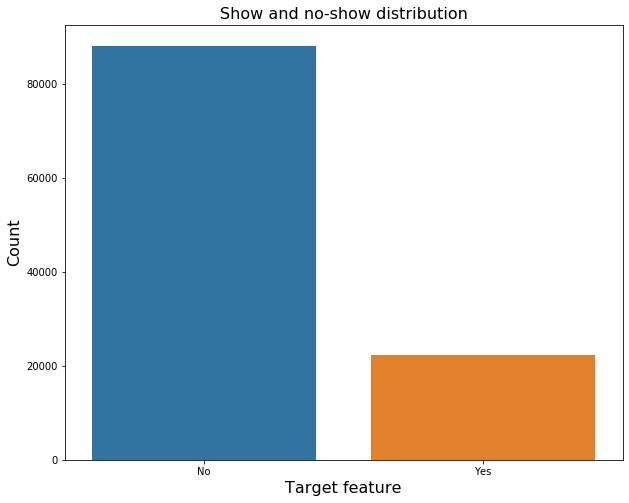

In [5]:
# visualizing target feature
plt.figure(figsize=(10,8))
sns.countplot(x='No-show', data=aptmnt_df)
plt.title('Show and no-show distribution', size=16)
plt.xlabel('Target feature', size=16)
plt.ylabel('Count', size=16)
# plt.legend(['No', 'Yes'])
plt.show()

# convert 'yes' 'no' to binary
aptmnt_df['No-show'] = aptmnt_df['No-show'].map(dict(Yes=1, No=0))

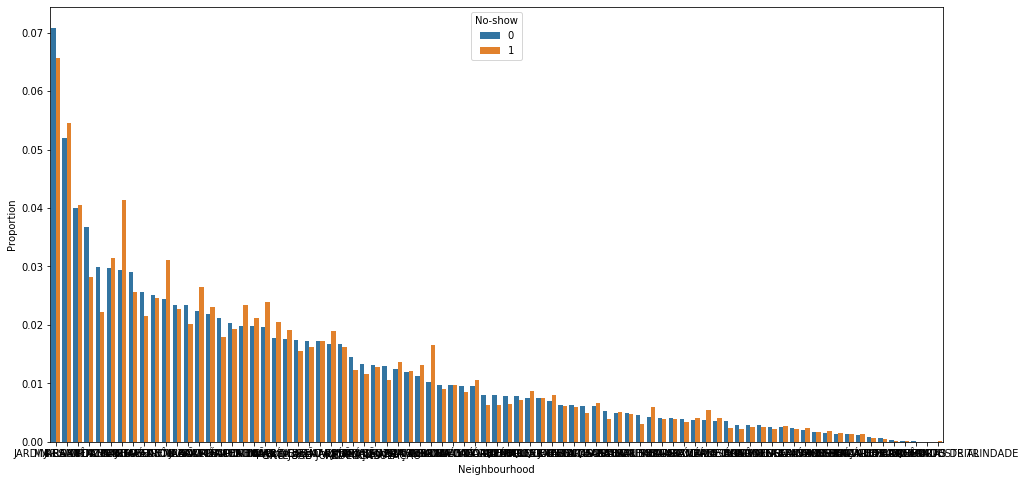

In [6]:
# does the neighborhood variable have an influence of no-show?
plt.figure(figsize=(16,8))
# sns.countplot(x='Neighbourhood', hue='No-show' ,data=aptmnt_df)

x, y, hue = "Neighbourhood", "Proportion", "No-show"
hue_order = ["No-show", "Show"]

(aptmnt_df[x]
 .groupby(aptmnt_df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

plt.show()

It seems that No-show and Show categories are equal for almost all neighborhoods. Will eliminate this information from further analysis

In [7]:
# drop neighborhood variable
aptmnt_df.drop('Neighbourhood', axis=1, inplace=True)

# get dummies of categorial variables
categorial = ['Gender', 'Day_of_week', 'Month']

aptmnt_df = dummies(aptmnt_df, list_cols=categorial)
aptmnt_df.head()

,PatientId,AppointmentID,ScheduledDay,AppointmentDay,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,...,No-show,Wait_period,Gender_M,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Month_Jun,Month_May
0,2.987250e+13,5642903,2016-04-29 18:38:08,2016-04-29 23:59:59,62,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.589978e+14,5642503,2016-04-29 16:08:27,2016-04-29 23:59:59,56,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,4.262962e+12,5642549,2016-04-29 16:19:04,2016-04-29 23:59:59,62,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8.679512e+11,5642828,2016-04-29 17:29:31,2016-04-29 23:59:59,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.841186e+12,5642494,2016-04-29 16:07:23,2016-04-29 23:59:59,56,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# remove unnecessary PatientID and AppointmentID columns
aptmnt_df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

In [ ]:
# use random forest classifier to idnetify most important features

data = aptmnt_df.drop(['No-show', 'AppointmentDay', 'ScheduledDay'], axis=1)
target = aptmnt_df['No-show']
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.2)

from sklearn.ensemble import RandomForestClassifier
feat_labels = data_train.columns
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(data_train, target_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(data_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[f],importances[indices[f]]))

In [ ]:
title('Feature Importances')
bar(range(data_train.shape[1]), importances[indices], align='center')
xticks(range(X_train.shape[1]),
feat_labels, rotation=90)
xlim([-1, X_train.shape[1]])
tight_layout()
show()

# Decision Tree

In [ ]:
# This is the model we'll be using.
from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# prepare data
data = aptmnt_df.drop(['No-show', 'AppointmentDay', 'ScheduledDay'], axis=1)
target = aptmnt_df['No-show']

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=2,
    max_depth=5
)

decision_tree.fit(data, target)

# Render our tree
plt.figure(figsize=(12,8))
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=data.columns,
    class_names=['No show', 'Show'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"25,25!"')
Image(graph.create_png())

In [ ]:
decision_tree.tree_.n_outputs

In [ ]:
help(decision_tree.tree_)